# English Data Notebook

## Import Libraries

In [ ]:
import json
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (f1_score, accuracy_score, recall_score,
                             precision_score, confusion_matrix, classification_report)
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump

## Import Datasets
from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainset_json = '/content/drive/My Drive/Thesis/Trainset/ML-ESG-3_Trainset_English.json'
testset_json = '/content/drive/My Drive/Thesis/Testset/ML-ESG3_Testset_EN.json'

Convert JSON files to dataframes

In [ ]:
with open(trainset_json, 'r') as file:
    train_json_data = json.load(file)

with open(testset_json, 'r') as file:
    test_json_data = json.load(file)

train_df = pd.json_normalize(train_json_data)
test_df = pd.json_normalize(test_json_data)

## Exploratory Data Analysis

In [ ]:
train_df.head()

URL  \
0  https://www.esgtoday.com/arabesque-ai-appoints...   
1  https://www.esgtoday.com/arabesque-ai-appoints...   
2  https://www.esgtoday.com/arabesque-ai-appoints...   
3  https://www.esgtoday.com/ukraine-war-inflation...   
4  https://www.esgtoday.com/eu-regulators-welcome...   

                                          news_title  \
0  Arabesque AI Appoints Carolina Minio Paluello ...   
1  Arabesque AI Appoints Carolina Minio Paluello ...   
2  Arabesque AI Appoints Carolina Minio Paluello ...   
3  Ukraine War, Inflation Reduction Act Driving F...   
4  EU Regulators Welcome, Critique New European S...   

                                        news_content impact_level  \
0  ESG-focused financial technology company Arabe...          low   
1  The company also announced the appointment of ...          low   
2  Wong said:  \n“Personalised portfolios demand ...       medium   
3  One of the key themes of the report is the imp...         high   
4  Europe’s three primary financial regulatory ag...       medium   

       impact_length  
0       2 to 5 years  
1       2 to 5 years  
2       2 to 5 years  
3  More than 5 years  
4  Less than 2 years

In [ ]:
print(f"Shape of the trainset: {train_df.shape}")
print(f"Shape of the testset: {test_df.shape}")

Shape of the trainset: (545, 5)
Shape of the testset: (136, 5)


In [ ]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   URL            545 non-null    object
 1   news_title     545 non-null    object
 2   news_content   545 non-null    object
 3   impact_level   545 non-null    object
 4   impact_length  545 non-null    object
dtypes: object(5)
memory usage: 21.4+ KB


None

In [ ]:
print(train_df.nunique())

URL              339
news_title       339
news_content     545
impact_level       3
impact_length      3
dtype: int64


From the above results we can observe that two features that are categorical, because they have only three unique values. Let's focus on these to features and make some insights.

In [ ]:
print("Below are the categorical values of impact_level")
train_df['impact_level'].unique()

Below are the categorical values of impact_level


array(['low', 'medium', 'high'], dtype=object)

In [ ]:
print("Below are the categorical values of impact_length")
train_df['impact_length'].unique()

Below are the categorical values of impact_length


array(['2 to 5 years', 'More than 5 years', 'Less than 2 years'],
      dtype=object)

In [ ]:
fig = px.histogram(train_df, x='impact_level', nbins=30, marginal='rug', title='Distribution of Impact Level')
fig.update_layout(xaxis_title='impact_level', yaxis_title='Frequency')
fig.show()

Our dataset for impact level classification demonstrates a moderate imbalance. The distribution of classes is as follows: low (106), medium (243), and high (196), which translates to approximately 25%, 57%, and 18% of the total samples, respectively.

In this context, the "low" class is the minority class, which may present challenges during model training, particularly if the model tends to favor the majority class. Conversely, the "medium" class serves as the majority, offering the model a substantial amount of data to learn from. This imbalance highlights the need for careful consideration in our modeling approach to ensure effective classification across all classes.

In [ ]:
fig = px.histogram(train_df, x='impact_length', nbins=30, marginal='rug', title='Distribution of Impact Length')
fig.update_layout(xaxis_title='impact_length', yaxis_title='Frequency')
fig.show()

Our dataset for impact length classification exhibits a moderate imbalance. The distribution of classes is as follows: less than 2 years (82), 2 to 5 years (198), and more than 5 years (265), which corresponds to approximately 19%, 46%, and 35% of the total samples, respectively.

In this case, the "less than 2 years" class is the minority, which may pose challenges during model training, especially if the model tends to favor the majority classes. Meanwhile, the "more than 5 years" class represents the majority, providing the model with a robust amount of data to learn from. This imbalance underscores the importance of adopting careful strategies in our modeling approach to ensure effective classification across all classes.



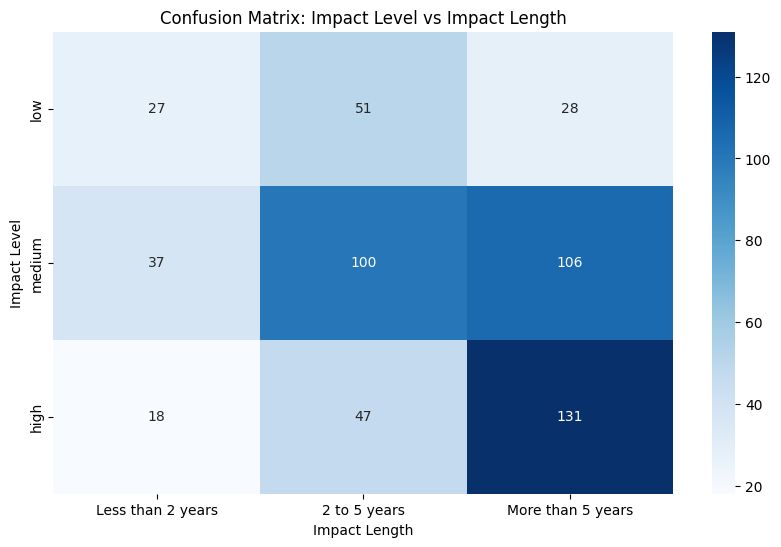

In [ ]:
train_df['impact_length'] = pd.Categorical(
    train_df['impact_length'],
    categories=['Less than 2 years', '2 to 5 years', 'More than 5 years'],
    ordered=True
)

train_df['impact_level'] = pd.Categorical(
    train_df['impact_level'],
    categories=['low', 'medium', 'high'],
    ordered=True
)

conf_matrix = pd.crosstab(train_df['impact_level'], train_df['impact_length'], rownames=['Impact Level'], colnames=['Impact Length'])
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix: Impact Level vs Impact Length')
plt.show()

From the above confusion matrix we can observe many things. Firstly, we can see that most cases are associated with "More than 5 years" as we have 131+106+28=265 cases. The data shows that high-impact projects are usually longer, especially those lasting "More than 5 years", indicating that longer projects often have a greater impact. Medium-impact projects are spread fairly evenly across different durations, suggesting that time doesn't heavily influence their impact level. On the other hand, low-impact projects tend to be shorter, with most lasting "2 to 5 years" or "less than 2 years", and fewer extending "More than 5 years".

<ipython-input-13-587c5fccf333>:26: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



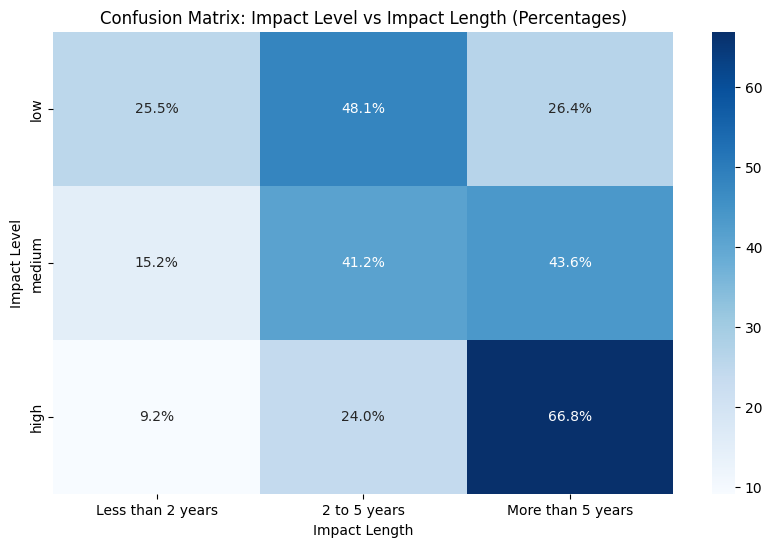

In [ ]:
train_df['impact_length'] = pd.Categorical(
    train_df['impact_length'],
    categories=['Less than 2 years', '2 to 5 years', 'More than 5 years'],
    ordered=True
)

# Ensure the 'impact_level' column is ordered as a categorical variable with correct order
train_df['impact_level'] = pd.Categorical(
    train_df['impact_level'],
    categories=['low', 'medium', 'high'],
    ordered=True
)

# Create the confusion matrix
conf_matrix = pd.crosstab(train_df['impact_level'], train_df['impact_length'], rownames=['Impact Level'], colnames=['Impact Length'])

# Calculate percentages
conf_matrix_percent = conf_matrix.apply(lambda r: r / r.sum() * 100, axis=1)  # Row-wise percentage

# Add row and column sums to the original matrix
conf_matrix_with_totals = conf_matrix.copy()
conf_matrix_with_totals.loc['Total'] = conf_matrix.sum(axis=0)  # Column totals
conf_matrix_with_totals['Total'] = pd.concat([conf_matrix.sum(axis=1), pd.Series(conf_matrix.sum().sum(), index=['Total'])])  # Row totals

# Prepare the text for the annotations (percentages)
annot = conf_matrix_percent.applymap(lambda x: '{:.1f}%'.format(x))

# Plot the confusion matrix with percentages
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix_percent, annot=annot, fmt='', cmap='Blues')  # Display percentages
plt.title('Confusion Matrix: Impact Level vs Impact Length (Percentages)')
plt.show()

## Encoding Categorical Features
In this part the categorical features will be encoded in order to have more effective dataset.

In [ ]:
train_df["impact_level"] = train_df["impact_level"].replace(["low","medium","high"],[0,1,2])
train_df["impact_length"] = train_df["impact_length"].replace(["Less than 2 years","2 to 5 years","More than 5 years"],[0,1,2])
test_df["impact_level"] = test_df["impact_level"].replace(["low","medium","high"],[0,1,2])
test_df["impact_length"] = test_df["impact_length"].replace(["Less than 2 years","2 to 5 years","More than 5 years"],[0,1,2])

train_df

<ipython-input-14-d9efbd076fbd>:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-14-d9efbd076fbd>:1: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.

<ipython-input-14-d9efbd076fbd>:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-14-d9efbd076fbd>:2: FutureWarning:

The behavior of Series.repl

URL  \
0    https://www.esgtoday.com/arabesque-ai-appoints...   
1    https://www.esgtoday.com/arabesque-ai-appoints...   
2    https://www.esgtoday.com/arabesque-ai-appoints...   
3    https://www.esgtoday.com/ukraine-war-inflation...   
4    https://www.esgtoday.com/eu-regulators-welcome...   
..                                                 ...   
540  https://www.esgtoday.com/methane-emissions-det...   
541  https://www.esgtoday.com/eaton-appoints-harold...   
542  https://www.esgtoday.com/ssga-outlines-2021-st...   
543  https://www.esgtoday.com/survey-investors-shif...   
544  https://www.esgtoday.com/chicago-to-transition...   

                                            news_title  \
0    Arabesque AI Appoints Carolina Minio Paluello ...   
1    Arabesque AI Appoints Carolina Minio Paluello ...   
2    Arabesque AI Appoints Carolina Minio Paluello ...   
3    Ukraine War, Inflation Reduction Act Driving F...   
4    EU Regulators Welcome, Critique New European S...   
..                                                 ...   
540  Methane Emissions Detection Platform Kuva Rais...   
541  Eaton Appoints Harold Jones as Chief Sustainab...   
542  SSGA Outlines 2021 Stewardship Priorities, Wil...   
543  Survey: Investors Shifting to Offense on Clima...   
544  Chicago to Transition Buildings, Airports & Op...   

                                          news_content impact_level  \
0    ESG-focused financial technology company Arabe...            0   
1    The company also announced the appointment of ...            0   
2    Wong said:  \n“Personalised portfolios demand ...            1   
3    One of the key themes of the report is the imp...            2   
4    Europe’s three primary financial regulatory ag...            1   
..                                                 ...          ...   
540  Stefan Bokaemper, CEO of Kuva Systems, said: “...            0   
541  Eaton Appoints Harold Jones as Chief Sustainab...            0   
542  In his letter, Taraporevala wrote: “As a signa...            1   
543  O’Brien said: “Investors globally are increasi...            0   
544  Jim McHugh, Chief Commercial Officer, Constell...            1   

    impact_length  
0               1  
1               1  
2               1  
3               2  
4               0  
..            ...  
540             1  
541             1  
542             0  
543             0  
544             1  

[545 rows x 5 columns]

## Split the Training an Validation Set
The Dataset now will be splitted into two datasets. The training set and the validation set. The test set it is already in a different dataset.


In [ ]:
levels = train_df.impact_level
train_inputs, val_inputs, train_level, val_level = train_test_split(train_df, levels, test_size=0.2, stratify=levels )

In [ ]:
print(len(train_inputs), len(train_level))

print(len(val_inputs), len(val_level))

436 436
109 109


In [ ]:
train_inputs = train_inputs.news_content
val_inputs = val_inputs.news_content

## TF-IDF

TF-IDF is a way to turn words into numbers so computers can understand them better. It looks at how often a word appears in a document and compares it to how often it appears in all the other documents. Words that are common in many documents (like "the" or "and") are given a lower score, while words that are rare but important (like "artificial intelligence" or "quantum computing") are given a higher score. This helps computers understand which words are most important in a document and can be used for things like sorting documents or finding related topics.

### Selected Parameters and Their Justifications:
lowercase=True:

Reason: Text data can have case variations that represent the same word (e.g., "Data" vs. "data"). To ensure consistency and avoid treating these as different terms, converting all text to lowercase is important. This helps reduce the dimensionality of the feature space and improve model accuracy by treating the same words consistently.
tokenizer=custom_tokenizer:

Reason: A custom tokenizer can be used to better handle the nuances of your text data, especially if you need to account for special symbols, remove punctuation, or split on specific characters. This offers more control over how the text is processed, allowing the TF-IDF representation to focus on meaningful words or phrases.
Example: You could define a tokenizer that removes URLs, handles numbers, or splits based on certain characters relevant to your task.
ngram_range=(1, 2):

Reason: This specifies that both unigrams (individual words) and bigrams (two consecutive words) will be considered as features. Using bigrams in addition to unigrams captures more context and can reveal important word pairings or common phrases that provide additional meaning beyond single words.
Example: For a corpus where phrases like "climate change" or "data science" are highly relevant, including bigrams can improve the feature set and the model’s understanding of key terms.
stop_words='english':

Reason: Stop words are common words (e.g., "and", "the", "is") that are usually irrelevant to the specific meaning of the document. Removing these helps reduce the noise in the data, allowing the TF-IDF to focus on more informative terms. The 'english' stop word list in sklearn is widely used and includes the most common stop words for English text.
Example: Removing stop words ensures that terms like "data" and "science" remain prominent in your vectorized data, while less informative words like "and" or "the" are discarded.
max_df=0.85:

Reason: This parameter excludes words that appear in more than 85% of the documents, assuming that such words are too common to be informative. These could be domain-specific stop words that don't add value to the analysis (e.g., "said" in news articles). This helps reduce dimensionality and focus on terms that are more unique to certain documents.
Example: In a dataset of news articles, "said" or "reported" might appear in nearly every document, so excluding them helps reduce noise.


In [ ]:
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
english_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
",".join(english_stopwords)

"i,me,my,myself,we,our,ours,ourselves,you,you're,you've,you'll,you'd,your,yours,yourself,yourselves,he,him,his,himself,she,she's,her,hers,herself,it,it's,its,itself,they,them,their,theirs,themselves,what,which,who,whom,this,that,that'll,these,those,am,is,are,was,were,be,been,being,have,has,had,having,do,does,did,doing,a,an,the,and,but,if,or,because,as,until,while,of,at,by,for,with,about,against,between,into,through,during,before,after,above,below,to,from,up,down,in,out,on,off,over,under,again,further,then,once,here,there,when,where,why,how,all,any,both,each,few,more,most,other,some,such,no,nor,not,only,own,same,so,than,too,very,s,t,can,will,just,don,don't,should,should've,now,d,ll,m,o,re,ve,y,ain,aren,aren't,couldn,couldn't,didn,didn't,doesn,doesn't,hadn,hadn't,hasn,hasn't,haven,haven't,isn,isn't,ma,mightn,mightn't,mustn,mustn't,needn,needn't,shan,shan't,shouldn,shouldn't,wasn,wasn't,weren,weren't,won,won't,wouldn,wouldn't"

## Machine Learning Models
As we can easily see, this project is a multi-class classification problem. For this reason we will use the belos **machine learning models**:


*   Multinomial Logistic Regression
*   Random Forest
*   Support Vector Machines
*   Naive Bayes
*   Gradient Boosting Machines (XGBoost)

We will conduct a grid search and evaluate the machine learning model using various parameters and different combinations. The grid search will identify the optimal combination of parameters that yields the highest F1 score.

### Multinomial Logistic Regression

In [ ]:

tfidf_params = {
    'tfidf__lowercase': [True, False],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [ 500, 1000, 2000],
    'tfidf__stop_words': [None, english_stopwords],
}

logistic_params = {
    'logistic__C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'logistic__solver': ['lbfgs'],
    'logistic__multi_class': ['multinomial'],
    'logistic__class_weight': ['balanced']
}

param_grid = {**tfidf_params, **logistic_params}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logistic', LogisticRegression(max_iter=500))
])

grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=5, verbose=2,  error_score='raise')
grid_search.fit(train_inputs, train_level)

print("Best combination of parameters are:")
print(grid_search.best_params_)
print(f"Best F1 score: {grid_search.best_score_}")
y_pred = grid_search.predict(val_inputs)
f1 = f1_score(val_level, y_pred, average='macro')
print(f"Validation F1 score: {f1}")


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.4s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.001, logistic__class_weig

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'beca

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.001, logistic__class_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'be

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'be

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'wha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'agai

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'agai

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', '

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'agai

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.001, logistic__cl

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'agai

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', '

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'agai

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.01, logistic__class_weight=ba

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'becaus

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.01, logistic__class_weigh

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'beca

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'beca

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'beca

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'be

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'be

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'whic

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'w

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'w

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'w

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'becaus

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'beca

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'beca

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'becaus

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'becaus

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'becaus

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'beca

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'beca

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'beca

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'beca

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'beca

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'wha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=None; total time=   0.2s
[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'be

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=False, tfidf__max_features=2000, tfidf__ngram_range=(1, 2), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



### Random Forest

In [ ]:
tfidf_params = {
    'tfidf__lowercase': [True],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [2000, 3000, 5000],
    'tfidf__stop_words': [None, english_stopwords],
}


rf_params = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [5, 10, 15],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__class_weight': ['balanced'],
    'rf__bootstrap': [True]
}

param_grid = {**tfidf_params, **rf_params}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=3, verbose=2)
grid_search.fit(train_inputs, train_level)


print("Best parameters set found:")
print(grid_search.best_params_)
print(f"Best F1 score: {grid_search.best_score_}")
y_pred = grid_search.predict(val_inputs)
f1 = f1_score(val_level, y_pred, average='macro')
print(f"Validation F1 score: {f1}")

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] END rf__bootstrap=True, rf__class_weight=balanced, rf__max_depth=5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.5s
[CV] END rf__bootstrap=True, rf__class_weight=balanced, rf__max_depth=5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.3s
[CV] END rf__bootstrap=True, rf__class_weight=balanced, rf__max_depth=5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50, tfidf__lowercase=True, tfidf__max_features=2000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.2s
[CV] END rf__bootstrap=True, rf__class_weight=balanced, rf__max_depth=5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50, tfidf__

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast



Best parameters set found:
{'rf__bootstrap': True, 'rf__class_weight': 'balanced', 'rf__max_depth': 15, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100, 'tfidf__lowercase': True, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}
Best F1 score: 0.5132368453320563
Validation F1 score: 0.549623216289883


### Support Vector Machines

In [ ]:
tfidf_params = {
    'tfidf__lowercase': [True, False],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [1000, 2000, 5000],
    'tfidf__stop_words': [None, english_stopwords]
}

svm_params = {
    'svm__C': [0.01, 0.1, 1],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.01],
    'svm__class_weight': ['balanced'],
}

param_grid = {**tfidf_params, **svm_params}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC()),
])

grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=5, verbose=2)


grid_search.fit(train_inputs, train_level)

print("Best parameters set found:")
print(grid_search.best_params_)
print(f"Best F1 score: {grid_search.best_score_}")

y_pred = grid_search.predict(val_inputs)
f1 = f1_score(val_level, y_pred, average='macro')
print(f"Validation F1 score: {f1}")


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END svm__C=0.01, svm__class_weight=balanced, svm__gamma=scale, svm__kernel=linear, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END svm__C=0.01, svm__class_weight=balanced, svm__gamma=scale, svm__kernel=linear, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END svm__C=0.01, svm__class_weight=balanced, svm__gamma=scale, svm__kernel=linear, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END svm__C=0.01, svm__class_weight=balanced, svm__gamma=scale, svm__kernel=linear, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END svm__C=0.01, svm__class_weight=balanced, svm__gamma=scale, svm__kernel=linear, tfidf__lowercase=Tru

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast



### Naive Bayes

In [ ]:
tfidf_params = {
    'tfidf__lowercase': [True, False],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [1000, 2000, 5000],
    'tfidf__stop_words': [None,  english_stopwords]
}

nb_params = {
    'nb__alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0],
}

param_grid = {**tfidf_params, **nb_params}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=5, verbose=2)

grid_search.fit(train_inputs, train_level)

print("Best parameters set found:")
print(grid_search.best_params_)
print(f"Best F1 score: {grid_search.best_score_}")

y_pred = grid_search.predict(val_inputs)

f1 = f1_score(val_level, y_pred, average='macro')
print(f"Validation F1 score: {f1}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END nb__alpha=0.01, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END nb__alpha=0.01, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.4s
[CV] END nb__alpha=0.01, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END nb__alpha=0.01, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END nb__alpha=0.01, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.1s
[CV] END nb__alpha=0.01, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll",

### XGBoost

In [ ]:
tfidf_params = {
    'tfidf__lowercase': [True],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [500, 1000],  # Reduced features for testing
    'tfidf__stop_words': [None, english_stopwords]
}

xgb_params = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.05],
    'xgb__gamma': [0.01],
    'xgb__subsample': [0.7, 0.8, 1.0],
}

param_grid = {**tfidf_params, **xgb_params}

# Define pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier(eval_metric='mlogloss'))
])

# GridSearch with StratifiedKFold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=StratifiedKFold(n_splits=2), verbose=2)

# Fit the model
grid_search.fit(train_inputs, train_level)

# Output the best parameters and scores
print("Best parameters set found:")
print(grid_search.best_params_)
print(f"Best F1 score: {grid_search.best_score_}")

# Evaluate on validation data
y_pred = grid_search.predict(val_inputs)
f1 = f1_score(val_level, y_pred, average='macro')
print(f"Validation F1 score: {f1}")

Fitting 2 folds for each of 288 candidates, totalling 576 fits
[CV] END tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None, xgb__gamma=0.01, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.7; total time=   2.4s
[CV] END tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None, xgb__gamma=0.01, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.7; total time=   4.1s
[CV] END tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None, xgb__gamma=0.01, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.9s
[CV] END tfidf__lowercase=True, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__stop_words=None, xgb__gamma=0.01, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s
[CV] END tfidf__l

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast



Best parameters set found:
{'tfidf__lowercase': True, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'a

## Test Dataset

In this section, we will evaluate all machine learning models that achieved the highest F1-score following hyperparameter tuning.

In [ ]:
test_inputs = test_df.news_content
test_labels = test_df.impact_level

In [ ]:
print(len(test_inputs), len(test_labels))

136 136


### Logistic Regression


The selected hyperparameters for the Logistic Regression model contribute significantly to its outstanding performance, particularly evident in its highest F1-score among the tested models. The TF-IDF settings include 'lowercase' set to False, 'ngram_range' at (1, 1) for unigrams, and a tailored list of 'stop_words' (english_stopwords). This configuration helps the model focus on important features while reducing noise from common words. Additionally, the Logistic Regression parameters, with a regularization strength ('C') of 10.0, a 'multi_class' setting of 'multinomial', and the 'lbfgs' solver, effectively enhance its training for multi-class scenarios.

In [ ]:
tfidf_params = {
    'lowercase': True,
    'ngram_range': (1, 2),
    'max_features': 1000,
    'stop_words': english_stopwords
    }

logistic_params = {
    'C': 0.1,
    'multi_class': 'multinomial',
    'solver': 'lbfgs',
    'class_weight': 'balanced'
}

# Create the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('logistic', LogisticRegression(**logistic_params))
])

# Train the model
pipeline.fit(train_inputs, train_level)

# Save the trained model
dump(pipeline, 'trained_model.joblib')

# Make predictions
predictions = pipeline.predict(test_inputs)

# Calculate evaluation metrics
f1 = f1_score(test_labels, predictions, average='macro')
accuracy = accuracy_score(test_labels, predictions)
recall = recall_score(test_labels, predictions, average='macro')
precision = precision_score(test_labels, predictions, average='macro')
conf_matrix = confusion_matrix(test_labels, predictions)

# Output results
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(test_labels, predictions))

F1 Score: 0.589295985866305
Accuracy: 0.625
Recall: 0.6018001550902846
Precision: 0.5815871083673884
Confusion Matrix:
 [[ 9  6  2]
 [ 9 33 17]
 [ 3 14 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.53      0.47        17
           1       0.62      0.56      0.59        59
           2       0.69      0.72      0.70        60

    accuracy                           0.62       136
   macro avg       0.58      0.60      0.59       136
weighted avg       0.63      0.62      0.63       136



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



### Random Forest

The chosen hyperparameters for the Random Forest model play a crucial role in enhancing its performance, as demonstrated by its notable F1-score among the models assessed. The TF-IDF configuration includes 'lowercase' set to True, which standardizes the text for uniformity, and an 'ngram_range' of (1, 2) that captures both unigrams and bigrams to enrich the feature set. By limiting the maximum number of features to 1000, the model focuses on the most significant terms, while the inclusion of a specified list of 'stop_words' (english_stopwords) minimizes noise from frequently used words. For the Random Forest parameters, utilizing 'class_weight' set to 'balanced' effectively addresses any class imbalance by adjusting weights based on class frequency. A 'max_depth' of 10 helps prevent overfitting by restricting the growth of individual trees, while 'min_samples_leaf' of 2 and 'min_samples_split' of 5 maintain a suitable balance between complexity and generalization. With 50 trees ('n_estimators'), the ensemble method enhances the model's predictive capabilities.

In [ ]:
tfidf_params = {
    'lowercase': True,
    'max_features': 5000,
    'ngram_range': (1, 1),
    'stop_words': None
}

rf_params = {
    'bootstrap': True,
    'class_weight': 'balanced',
    'max_depth': 15,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100
}

# Create the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('rf', RandomForestClassifier(**rf_params))
])

# Train the model
pipeline.fit(train_inputs, train_level)

# Save the trained model
dump(pipeline, 'trained_model.joblib')

# Make predictions
predictions = pipeline.predict(test_inputs)

# Calculate evaluation metrics
f1 = f1_score(test_labels, predictions, average='macro')
accuracy = accuracy_score(test_labels, predictions)
recall = recall_score(test_labels, predictions, average='macro')
precision = precision_score(test_labels, predictions, average='macro')
conf_matrix = confusion_matrix(test_labels, predictions)

# Output results
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(test_labels, predictions))

F1 Score: 0.49235320586090436
Accuracy: 0.5588235294117647
Recall: 0.48229201285033785
Precision: 0.5388396375098502
Confusion Matrix:
 [[ 4 11  2]
 [ 4 41 14]
 [ 1 28 31]]
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.24      0.31        17
           1       0.51      0.69      0.59        59
           2       0.66      0.52      0.58        60

    accuracy                           0.56       136
   macro avg       0.54      0.48      0.49       136
weighted avg       0.57      0.56      0.55       136



### Support Vector Machine


The hyperparameters selected for the Support Vector Machine (SVM) model significantly contribute to its effectiveness, as evidenced by its competitive F1-score among the evaluated models. The TF-IDF settings include 'lowercase' set to True, ensuring uniformity in the text data, and an 'ngram_range' of (1, 2), which captures both unigrams and bigrams to provide a richer representation of the features. By limiting the maximum number of features to 1000 and employing a tailored list of 'stop_words' (english_stopwords), the model effectively focuses on the most relevant terms while filtering out common noise. The SVM parameters include a regularization strength ('C') of 1, which balances the trade-off between maximizing the margin and minimizing classification errors. The 'class_weight' parameter is set to 'balanced', addressing any class imbalance by adjusting the weights of different classes accordingly. Additionally, 'gamma' set to 'scale' optimizes the influence of individual training examples, while the 'linear' kernel promotes simplicity and efficiency in separating the classes.

In [ ]:
tfidf_params = {
    'lowercase': True,
    'max_features': 2000,
    'ngram_range': (1, 1),  # Unigrams
    'stop_words': english_stopwords
}

svm_params = {
    'C': 1,
    'class_weight': 'balanced',
    'gamma': 'scale',
    'kernel': 'linear'
}

# Create a pipeline with TfidfVectorizer and SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),  # TF-IDF Vectorizer with parameters
    ('svm', SVC(**svm_params))  # SVM Classifier with parameters
])

# Fit the pipeline on your training data
pipeline.fit(train_inputs, train_level)

# Save the fitted model
dump(pipeline, 'trained_model.joblib')

# Predict on the test dataset
predictions = pipeline.predict(test_inputs)

# Calculate metrics
f1 = f1_score(test_labels, predictions, average='macro')
accuracy = accuracy_score(test_labels, predictions)
recall = recall_score(test_labels, predictions, average='macro')
precision = precision_score(test_labels, predictions, average='macro')
conf_matrix = confusion_matrix(test_labels, predictions)

# Print results
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(test_labels, predictions))

F1 Score: 0.5806190476190477
Accuracy: 0.6176470588235294
Recall: 0.5827572837044422
Precision: 0.5822973322973324
Confusion Matrix:
 [[ 8  7  2]
 [ 7 39 13]
 [ 3 20 37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.47      0.46        17
           1       0.59      0.66      0.62        59
           2       0.71      0.62      0.66        60

    accuracy                           0.62       136
   macro avg       0.58      0.58      0.58       136
weighted avg       0.63      0.62      0.62       136



### Multinomial Naive Bayes


The hyperparameters chosen for the Naive Bayes (NB) model play a crucial role in its performance, as reflected in its F1-score among the other models tested. The TF-IDF configuration includes 'lowercase' set to True, ensuring consistent treatment of words, while the 'ngram_range' of (1, 2) allows the model to consider both unigrams and bigrams, enhancing its understanding of the context in which words appear. By setting the maximum number of features to 1000 and utilizing a tailored list of 'stop_words' (english_stopwords), the model can effectively highlight significant terms while filtering out common noise. The Naive Bayes parameter, 'alpha', is set to 0.1, which applies Laplace smoothing to handle zero probabilities, ensuring that all features contribute to the classification.

In [ ]:
tfidf_params = {
    'lowercase': True,
    'max_features': 1000,
    'ngram_range': (1, 2),  # Unigrams and bigrams
    'stop_words': english_stopwords
}

nb_params = {
    'alpha': 0.05
}

# Create a pipeline with TfidfVectorizer and MultinomialNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),  # TF-IDF Vectorizer with parameters
    ('nb', MultinomialNB(**nb_params))  # Multinomial Naive Bayes Classifier with parameters
])

# Fit the pipeline on your training data
pipeline.fit(train_inputs, train_level)

# Save the fitted model
dump(pipeline, 'trained_model.joblib')

# Predict on the test dataset
predictions = pipeline.predict(test_inputs)

# Calculate metrics
f1 = f1_score(test_labels, predictions, average='macro')
accuracy = accuracy_score(test_labels, predictions)
recall = recall_score(test_labels, predictions, average='macro')
precision = precision_score(test_labels, predictions, average='macro')
conf_matrix = confusion_matrix(test_labels, predictions)

# Print results
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(test_labels, predictions))

F1 Score: 0.4860773181941065
Accuracy: 0.5514705882352942
Recall: 0.47654813337764484
Precision: 0.5222222222222223
Confusion Matrix:
 [[ 4 11  2]
 [ 6 39 14]
 [ 0 28 32]]
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.24      0.30        17
           1       0.50      0.66      0.57        59
           2       0.67      0.53      0.59        60

    accuracy                           0.55       136
   macro avg       0.52      0.48      0.49       136
weighted avg       0.56      0.55      0.55       136



### XG-Boost




The chosen hyperparameters for the XGBoost model play a crucial role in enhancing its classification performance. The TF-IDF settings include 'lowercase' set to True for consistent word representation, an 'ngram_range' of (1, 1) to focus on unigrams, and a limit of 500 maximum features to reduce complexity. The use of a tailored list of 'stop_words' (english_stopwords) helps remove common terms that contribute little to the model's effectiveness. The XGBoost parameters feature a 'gamma' of 0.1, which controls model complexity by penalizing new splits; a 'learning_rate' of 0.1 to moderate the influence of each tree; a 'max_depth' of 5 to prevent overfitting; and 'n_estimators' set to 100, determining the number of boosting rounds. Together, these hyperparameters enable the XGBoost model to effectively manage complexity and enhance its performance on the dataset.

In [ ]:
tfidf_params = {
    'lowercase': True,
    'max_features': 500,
    'ngram_range': (1, 1),
    'stop_words': english_stopwords
}

xgb_params = {
    'gamma': 0.01,
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 200,
    'subsample': 1.0
}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('xgb', XGBClassifier(**xgb_params))
])

pipeline.fit(train_inputs, train_level)
dump(pipeline, 'trained_model.joblib')
predictions = pipeline.predict(test_inputs)

f1 = f1_score(test_labels, predictions, average='macro')
accuracy = accuracy_score(test_labels, predictions)
recall = recall_score(test_labels, predictions, average='macro')
precision = precision_score(test_labels, predictions, average='macro')
conf_matrix = confusion_matrix(test_labels, predictions)

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(test_labels, predictions))

F1 Score: 0.36417342056439805
Accuracy: 0.47794117647058826
Recall: 0.37911820095269744
Precision: 0.4101867572156197
Confusion Matrix:
 [[ 1 14  2]
 [ 3 42 14]
 [ 1 37 22]]
Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.06      0.09        17
           1       0.45      0.71      0.55        59
           2       0.58      0.37      0.45        60

    accuracy                           0.48       136
   macro avg       0.41      0.38      0.36       136
weighted avg       0.48      0.48      0.45       136



Let's now compare all the results and find which of these Machine Learning models give us the best results. To remind we had a train dataset which was multi class, spwcifically with three classes and was moderate imbalance. Let's firstly compare the f1-score :

| Model        | Train Dataset | Validation Dataset | Test Dataset |
|--------------|---------------|--------------------|--------------|
| Logistic Regression (LR) | 0.542         | 0.519              | 0.589 ⭐     |
| Random Forest (RF)       | 0.513         | 0.549 ⭐           | 0.492       |
| Support Vector Machine (SVM) | 0.538         | 0.545              | 0.580       |
| Naive Bayes (NB)        | 0.550 ⭐      | 0.527              | 0.486       |
| XGBoost                 | 0.435         | 0.498              | 0.364       |


In this analysis, the performance of various machine learning models was compared using F1 scores across training, validation, and test datasets. Logistic Regression (LR) emerged as the best performer overall, achieving an F1 score of 0.589 on the test dataset, indicating robust generalization. Random Forest (RF) led the validation dataset with a score of 0.549, but showed a decline to 0.492 on the test dataset, suggesting potential overfitting. Support Vector Machine (SVM) maintained balanced performance across all datasets, with scores ranging from 0.538 (train) to 0.580 (test). Naive Bayes (NB) excelled in the training dataset (0.550) but experienced a drop in performance on validation and test datasets, highlighting its limitations in handling imbalanced classes. Conversely, XGBoost consistently underperformed, scoring 0.364 on the test dataset, indicating that its current hyperparameters may not be suitable for this multi-class, moderately imbalanced task. Overall, while LR proved to be the strongest candidate, there is room for improvement in tuning parameters and exploring techniques to address class imbalance, particularly for the models that struggled.

Although the best models identified are Logistic Regression (LR) and Support Vector Machine (SVM), both the F1 score and accuracy remain relatively low. Therefore, further hyperparameter tuning will be performed, focusing solely on the SVM model. The results obtained from the training set are as follows:

In [ ]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import spacy
import nltk
nltk.download('punkt')
stemmer = PorterStemmer()
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### LR with stemming

In [ ]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

stemmer = PorterStemmer()

def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

def preprocessor(text):
    tokens = word_tokenize(text)
    stemmed = stem_tokens(tokens)
    return ' '.join(stemmed)

tfidf_params = {
    'lowercase': True,
    'ngram_range': (1, 2),
    'max_features': 1000,
    'stop_words': english_stopwords,
    'preprocessor': preprocessor
}

# Logistic Regression parameters
logistic_params = {
    'C': 0.1,
    'multi_class': 'multinomial',
    'solver': 'lbfgs',
    'class_weight': 'balanced'
}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('logistic', LogisticRegression(**logistic_params))
])

pipeline.fit(train_inputs, train_level)
dump(pipeline, 'trained_model.joblib')

train_preds = pipeline.predict(train_inputs)
val_preds = pipeline.predict(val_inputs)
test_preds = pipeline.predict(test_inputs)

f1_train = f1_score(train_level, train_preds, average='macro')
f1_val = f1_score(val_level, val_preds, average='macro')
f1_test = f1_score(test_labels, test_preds, average='macro')
print(f"F1 Score on Training Set: {f1_train}")
print(f"F1 Score on Validation Set: {f1_val}")
print(f"F1 Score on Test Set: {f1_test}")

accuracy = accuracy_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds, average='macro')
precision = precision_score(test_labels, test_preds, average='macro')
conf_matrix = confusion_matrix(test_labels, test_preds)
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(test_labels, test_preds))


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



F1 Score on Training Set: 0.8176446119462991
F1 Score on Validation Set: 0.5313399778516058
F1 Score on Test Set: 0.566467958271237
Accuracy: 0.5882352941176471
Recall: 0.5876980170599314
Precision: 0.5549001274188964
Confusion Matrix:
 [[10  5  2]
 [11 29 19]
 [ 2 17 41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.59      0.50        17
           1       0.57      0.49      0.53        59
           2       0.66      0.68      0.67        60

    accuracy                           0.59       136
   macro avg       0.55      0.59      0.57       136
weighted avg       0.59      0.59      0.59       136



with lemmatization


In [ ]:


# Define the lemmatization function
def lemmatize_text_spacy(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# Define TF-IDF parameters with the custom lemmatization preprocessor
tfidf_params = {
    'lowercase': True,
    'ngram_range': (1, 2),
    'max_features': 1000,
    'stop_words': english_stopwords,
    'preprocessor': lemmatize_text_spacy  # Apply lemmatization here
}

# Define Logistic Regression parameters
logistic_params = {
    'C': 0.1,
    'multi_class': 'multinomial',
    'solver': 'lbfgs',
    'class_weight': 'balanced'
}

# Create the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('logistic', LogisticRegression(**logistic_params))
])

pipeline.fit(train_inputs, train_level)
dump(pipeline, 'trained_model.joblib')

train_preds = pipeline.predict(train_inputs)
val_preds = pipeline.predict(val_inputs)
test_preds = pipeline.predict(test_inputs)

f1_train = f1_score(train_level, train_preds, average='macro')
f1_val = f1_score(val_level, val_preds, average='macro')
f1_test = f1_score(test_labels, test_preds, average='macro')
print(f"F1 Score on Training Set: {f1_train}")
print(f"F1 Score on Validation Set: {f1_val}")
print(f"F1 Score on Test Set: {f1_test}")

accuracy = accuracy_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds, average='macro')
precision = precision_score(test_labels, test_preds, average='macro')
conf_matrix = confusion_matrix(test_labels, test_preds)
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(test_labels, test_preds))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



F1 Score on Training Set: 0.8413046772596117
F1 Score on Validation Set: 0.5609308831272859
F1 Score on Test Set: 0.5477503518496817
Accuracy: 0.5588235294117647
Recall: 0.5794339204608397
Precision: 0.53315649867374
Confusion Matrix:
 [[11  4  2]
 [12 28 19]
 [ 3 20 37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.65      0.51        17
           1       0.54      0.47      0.50        59
           2       0.64      0.62      0.63        60

    accuracy                           0.56       136
   macro avg       0.53      0.58      0.55       136
weighted avg       0.57      0.56      0.56       136



with stemming and lemmatization

In [ ]:
stemmer = PorterStemmer()

# Define the lemmatization and stemming function
def lemmatize_and_stem(text):
    # Lemmatization using spaCy
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]

    # Stemming using NLTK
    stemmed_words = [stemmer.stem(word) for word in lemmatized_words]

    return ' '.join(stemmed_words)

# Define TF-IDF parameters with the custom preprocessing function
tfidf_params = {
    'lowercase': True,
    'ngram_range': (1, 2),
    'max_features': 1000,
    'stop_words': english_stopwords,
    'preprocessor': lemmatize_and_stem  # Apply both lemmatization and stemming
}

# Define Logistic Regression parameters
logistic_params = {
    'C': 0.1,
    'multi_class': 'multinomial',
    'solver': 'lbfgs',
    'class_weight': 'balanced'
}

# Create the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('logistic', LogisticRegression(**logistic_params))
])

pipeline.fit(train_inputs, train_level)
dump(pipeline, 'trained_model.joblib')

train_preds = pipeline.predict(train_inputs)
val_preds = pipeline.predict(val_inputs)
test_preds = pipeline.predict(test_inputs)

f1_train = f1_score(train_level, train_preds, average='macro')
f1_val = f1_score(val_level, val_preds, average='macro')
f1_test = f1_score(test_labels, test_preds, average='macro')
print(f"F1 Score on Training Set: {f1_train}")
print(f"F1 Score on Validation Set: {f1_val}")
print(f"F1 Score on Test Set: {f1_test}")

accuracy = accuracy_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds, average='macro')
precision = precision_score(test_labels, test_preds, average='macro')
conf_matrix = confusion_matrix(test_labels, test_preds)
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(test_labels, test_preds))


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



F1 Score on Training Set: 0.822537223305816
F1 Score on Validation Set: 0.5376095657901403
F1 Score on Test Set: 0.5718583315553659
Accuracy: 0.6029411764705882
Recall: 0.5989032901296112
Precision: 0.5615384615384615
Confusion Matrix:
 [[10  6  1]
 [12 30 17]
 [ 4 14 42]]
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.59      0.47        17
           1       0.60      0.51      0.55        59
           2       0.70      0.70      0.70        60

    accuracy                           0.60       136
   macro avg       0.56      0.60      0.57       136
weighted avg       0.62      0.60      0.61       136



In [ ]:
english_stopwords = list(stopwords.words('english'))
tfidf_params = {
    'tfidf__lowercase': [True],
    'tfidf__ngram_range': [(1, 2)],
    'tfidf__max_features': [1000],
    'tfidf__stop_words': [english_stopwords],
    'tfidf__preprocessor': [preprocessor, lemmatize_text_spacy, lemmatize_and_stem]  # Correcting this
}

logistic_params = {
    'logistic__C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'logistic__solver': ['lbfgs'],
    'logistic__multi_class': ['multinomial'],
    'logistic__class_weight': ['balanced']
}

param_grid = {**tfidf_params, **logistic_params}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Vectorizer step
    ('logistic', LogisticRegression(max_iter=500))  # Logistic regression step
])

# Run GridSearchCV with cross-validation and F1-macro scoring
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=5, verbose=2, error_score='raise')

# Fit the grid search model
grid_search.fit(train_inputs, train_level)

# Output best parameters and F1 score
print("Best combination of parameters are:")
print(grid_search.best_params_)
print(f"Best F1 score: {grid_search.best_score_}")

# Predict on the validation set and calculate F1 score
y_pred = grid_search.predict(val_inputs)
f1 = f1_score(val_level, y_pred, average='macro')
print(f"Validation F1 score: {f1}")


Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'oursel

[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'f

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'f

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'f

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'f

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.001, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'f

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'oursel

[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', '

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', '

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', '

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', '

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', '

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', '

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', '

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', '

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', '

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', '

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'fr

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'fr

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'fr

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'fr

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.01, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'fr

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'oursel

[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'u

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'u

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'u

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'u

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'u

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'f

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'f

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'f

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'f

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'f

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'fro

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'fro

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'fro

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'fro

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'fro

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'u

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'u

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'oursel

[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'u

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'u

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'u

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'f

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'f

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'f

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'f

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_text_spacy at 0x7f2169db3c70>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'f

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'fro

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'fro

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'fro

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'fro

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=1.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function lemmatize_and_stem at 0x7f2169db3640>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'fro

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', '

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', '

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', '

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', '

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[CV] END logistic__C=10.0, logistic__class_weight=balanced, logistic__multi_class=multinomial, logistic__solver=lbfgs, tfidf__lowercase=True, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f2205a060e0>, tfidf__stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', '

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.



KeyboardInterrupt: 

### Support Vector Machines

In [ ]:
def stem_text(text):
    words = nltk.word_tokenize(text)  # Tokenize the text
    stemmed_words = [stemmer.stem(word) for word in words]  # Apply stemming
    return ' '.join(stemmed_words)  # Return the joined stemmed words

# TF-IDF parameters
tfidf_params = {
    'lowercase': True,
    'max_features': 2000,
    'ngram_range': (1, 1),  # Unigrams
    'stop_words': english_stopwords,
    'preprocessor': stem_text  # Apply stemming in the preprocessor
}

# SVM parameters
svm_params = {
    'C': 1,
    'class_weight': 'balanced',
    'gamma': 'scale',
    'kernel': 'linear'
}

# Create a pipeline with TfidfVectorizer and SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),  # TF-IDF Vectorizer with parameters
    ('svm', SVC(**svm_params))  # SVM Classifier with parameters
])

pipeline.fit(train_inputs, train_level)
dump(pipeline, 'trained_model.joblib')

train_preds = pipeline.predict(train_inputs)
val_preds = pipeline.predict(val_inputs)
test_preds = pipeline.predict(test_inputs)

f1_train = f1_score(train_level, train_preds, average='macro')
f1_val = f1_score(val_level, val_preds, average='macro')
f1_test = f1_score(test_labels, test_preds, average='macro')
print(f"F1 Score on Training Set: {f1_train}")
print(f"F1 Score on Validation Set: {f1_val}")
print(f"F1 Score on Test Set: {f1_test}")

accuracy = accuracy_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds, average='macro')
precision = precision_score(test_labels, test_preds, average='macro')
conf_matrix = confusion_matrix(test_labels, test_preds)
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(test_labels, test_preds))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.



F1 Score on Training Set: 0.9674370563896248
F1 Score on Validation Set: 0.5812636165577342
F1 Score on Test Set: 0.5829737972795477
Accuracy: 0.625
Recall: 0.5742605516782984
Precision: 0.5970601537765717
Confusion Matrix:
 [[ 7  8  2]
 [ 6 39 14]
 [ 1 20 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.41      0.45        17
           1       0.58      0.66      0.62        59
           2       0.71      0.65      0.68        60

    accuracy                           0.62       136
   macro avg       0.60      0.57      0.58       136
weighted avg       0.63      0.62      0.62       136



In [ ]:
def lemmatize_text(text):
    doc = nlp(text)  # Process the text with spaCy
    lemmatized_words = [token.lemma_ for token in doc]  # Get lemmas
    return ' '.join(lemmatized_words)  # Return the joined lemmatized words

# TF-IDF parameters
tfidf_params = {
    'lowercase': True,
    'max_features': 2000,
    'ngram_range': (1, 1),  # Unigrams
    'stop_words': english_stopwords,
    'preprocessor': lemmatize_text  # Apply lemmatization in the preprocessor
}

# SVM parameters
svm_params = {
    'C': 1,
    'class_weight': 'balanced',
    'gamma': 'scale',
    'kernel': 'linear'
}

# Create a pipeline with TfidfVectorizer and SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),  # TF-IDF Vectorizer with parameters
    ('svm', SVC(**svm_params))  # SVM Classifier with parameters
])

pipeline.fit(train_inputs, train_level)
dump(pipeline, 'trained_model.joblib')

train_preds = pipeline.predict(train_inputs)
val_preds = pipeline.predict(val_inputs)
test_preds = pipeline.predict(test_inputs)

f1_train = f1_score(train_level, train_preds, average='macro')
f1_val = f1_score(val_level, val_preds, average='macro')
f1_test = f1_score(test_labels, test_preds, average='macro')
print(f"F1 Score on Training Set: {f1_train}")
print(f"F1 Score on Validation Set: {f1_val}")
print(f"F1 Score on Test Set: {f1_test}")

accuracy = accuracy_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds, average='macro')
precision = precision_score(test_labels, test_preds, average='macro')
conf_matrix = confusion_matrix(test_labels, test_preds)
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(test_labels, test_preds))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'far', 'might', 'must', 'need', 'sha', 'win', 'would'] not in stop_words.



F1 Score on Training Set: 0.9664221640855178
F1 Score on Validation Set: 0.5996681823767974
F1 Score on Test Set: 0.5063659854357528
Accuracy: 0.5514705882352942
Recall: 0.5044643846239061
Precision: 0.5145238095238095
Confusion Matrix:
 [[ 6  9  2]
 [ 6 37 16]
 [ 4 24 32]]
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.35      0.36        17
           1       0.53      0.63      0.57        59
           2       0.64      0.53      0.58        60

    accuracy                           0.55       136
   macro avg       0.51      0.50      0.51       136
weighted avg       0.56      0.55      0.55       136



In [ ]:
def lemmatize_and_stem(text):
    # Lemmatization using spaCy
    doc = nlp(text)  # Process the text with spaCy
    lemmatized_words = [token.lemma_ for token in doc]  # Get lemmas

    # Stemming using NLTK
    stemmed_words = [stemmer.stem(word) for word in lemmatized_words]  # Apply stemming
    return ' '.join(stemmed_words)  # Return the joined stemmed words

# TF-IDF parameters
tfidf_params = {
    'lowercase': True,
    'max_features': 2000,
    'ngram_range': (1, 1),
    'stop_words': english_stopwords,
    'preprocessor': lemmatize_and_stem
}

# SVM parameters
svm_params = {
    'C': 1,
    'class_weight': 'balanced',
    'gamma': 'scale',
    'kernel': 'linear'
}

# Create a pipeline with TfidfVectorizer and SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),  # TF-IDF Vectorizer with parameters
    ('svm', SVC(**svm_params))  # SVM Classifier with parameters
])

pipeline.fit(train_inputs, train_level)
dump(pipeline, 'trained_model.joblib')

train_preds = pipeline.predict(train_inputs)
val_preds = pipeline.predict(val_inputs)
test_preds = pipeline.predict(test_inputs)

f1_train = f1_score(train_level, train_preds, average='macro')
f1_val = f1_score(val_level, val_preds, average='macro')
f1_test = f1_score(test_labels, test_preds, average='macro')
print(f"F1 Score on Training Set: {f1_train}")
print(f"F1 Score on Validation Set: {f1_val}")
print(f"F1 Score on Test Set: {f1_test}")

accuracy = accuracy_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds, average='macro')
precision = precision_score(test_labels, test_preds, average='macro')
conf_matrix = confusion_matrix(test_labels, test_preds)
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(test_labels, test_preds))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'dure', 'far', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'win', 'would'] not in stop_words.



F1 Score on Training Set: 0.9616564314238731
F1 Score on Validation Set: 0.6121048762558197
F1 Score on Test Set: 0.5691433566433567
Accuracy: 0.6102941176470589
Recall: 0.563243602525756
Precision: 0.5833489827856025
Confusion Matrix:
 [[ 7  9  1]
 [ 6 40 13]
 [ 2 22 36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.41      0.44        17
           1       0.56      0.68      0.62        59
           2       0.72      0.60      0.65        60

    accuracy                           0.61       136
   macro avg       0.58      0.56      0.57       136
weighted avg       0.62      0.61      0.61       136



The results after stemming, lemmatization or both together are below :

**Logistic Regression**

| **Preprocessing**          | **Training Set** | **Validation Set** | **Test Set** |
|----------------------------|------------------|--------------------|--------------|
| Baseline                   | 0.542            | 0.519              | 0.589        |
| Stemming                   | 0.818            | 0.531              | 0.566        |
| Lemmatization              | 0.841            | 0.561              | 0.548        |
| Stemming + Lemmatization   | 0.823            | 0.538              | 0.572        |


**SVM**

| **Preprocessing**          | **Training Set** | **Validation Set** | **Test Set** |
|----------------------------|------------------|--------------------|--------------|
| Baseline                   | 0.538            | 0.545              | 0.580        |
| Stemming                   | 0.967            | 0.581              | 0.583        |
| Lemmatization              | 0.966            | 0.600              | 0.506        |
| Stemming + Lemmatization   | 0.962            | 0.612              | 0.569        |




The provided tables offer valuable insights into the performance of Logistic Regression and SVM models across various preprocessing techniques (baseline, stemming, lemmatization, and a combination of both) on training, validation, and test sets. For Logistic Regression, the baseline model shows moderate performance with F1 scores around 0.54-0.59, indicating reasonable generalization. Stemming significantly improves training performance (F1 = 0.818) but leads to overfitting, as validation and test scores drop to 0.531 and 0.566, respectively. In contrast, lemmatization delivers the best results among the preprocessing methods, achieving F1 scores of 0.841, 0.561, and 0.548 on the training, validation, and test sets, suggesting better generalization than stemming. The combination of both techniques yields moderate results, with training, validation, and test scores of 0.823, 0.538, and 0.572, respectively, indicating a balance between generalization and overfitting. For SVM, the baseline model maintains consistent performance (F1 around 0.54-0.58), reflecting a well-balanced fit. However, stemming leads to significant overfitting, producing a very high training F1 score (0.967) while validation and test scores fall to 0.581 and 0.583. Lemmatization also shows high training performance (0.966) but exhibits poor generalization with a test score of 0.506. The combination of stemming and lemmatization provides a slight improvement in generalization, with validation and test scores of 0.612 and 0.569, respectively. Overall, lemmatization and the combination of both methods appear to enhance generalization, while stemming alone tends to result in overfitting, especially within the SVM model.
